## パッケージのインポート

モデルの構築に必要な TensorFlow と Keras クラスをインポートします。

In [4]:
import tensorflow as tf

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

便宜上、データセットの前処理およびネットワークの学習中に使用する変数を設定します。

In [1]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 100
IMG_WIDTH = 100

## データ拡張（Data augmentation）

### データ拡張を同時に利用する

すべてのデータ拡張機能を適用します。ここでは、学習用画像に対して、リスケール、45度の回転、幅シフト、高さシフト、水平反転、ズームを適用しました。

In [13]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [14]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory='../web_API/tensoflow/data/train',
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 529 images belonging to 3 classes.


### 検証データジェネレータの構築

一般に、データ拡張は学習サンプルのみに適用します。今回は、 `ImageDataGenerator` を使用して検証画像に対してリスケールのみを実施し、バッチに変換します。

In [15]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [16]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory='../web_API/tensoflow/data/test',
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 170 images belonging to 3 classes.


### ドロップアウト（dropout）

過学習を避けるもう一つの方法は、ネットワークに *ドロップアウト* を導入することです。これは、ネットワークにおいて重みを小さくする正則化の方式で、これによって重みの値の分布がより規則的になり、少ない学習データに対する過学習を減らすことができます。ドロップアウトはこのチュートリアルで利用される正則化手法の一つです。

ドロップアウトをレイヤーに適用すると、学習プロセス中に適用されたレイヤーのうちランダムに出力ユニットをドロップアウト（ゼロに設定）します。ドロップアウトは、入力値として0.1、0.2、0.4といった形式の小数をとります。これは、適用されたレイヤーからランダムに出力単位の10％、20％、または40％をドロップアウトすることを意味します。

特定のレイヤーに0.1ドロップアウトを適用すると、各学習エポックにおいて出力ユニットの10％がランダムに0にされます。

この新しいドロップアウト機能を使用したネットワークアーキテクチャを作成し、異なる畳み込みレイヤーや全接続レイヤーに適用してみましょう。

## モデル構築

ここでは、ドロップアウトを最初と最後の max pool 層に適用します。ドロップアウトを適用すると、各学習エポック中にニューロンの20％がランダムにゼロに設定されます。これにより、学習データセットに対する過学習を避けることができます。

In [17]:
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.45),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

### モデルのコンパイル

ネットワークにドロップアウトを導入した後、モデルをコンパイルし、レイヤーの概要を表示します。

In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 32)       

### モデルの学習

学習サンプルにデータ拡張を導入し、ネットワークにドロップアウトを追加した後、この新しいネットワークを学習します:

In [19]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=3,
    epochs=30,
    validation_data=val_data_gen,
    validation_steps=1
)

Epoch 1/30
3/3 [==============================] - 3s 985ms/step - loss: 3.9923 - accuracy: 0.3594 - val_loss: 1.3205 - val_accuracy: 0.3594
Epoch 2/30
3/3 [==============================] - 2s 826ms/step - loss: 1.4370 - accuracy: 0.4349 - val_loss: 1.0722 - val_accuracy: 0.4844
Epoch 3/30
3/3 [==============================] - 2s 671ms/step - loss: 1.0627 - accuracy: 0.4908 - val_loss: 1.1000 - val_accuracy: 0.5078
Epoch 4/30
3/3 [==============================] - 2s 575ms/step - loss: 1.0705 - accuracy: 0.4872 - val_loss: 1.0992 - val_accuracy: 0.4609
Epoch 5/30
3/3 [==============================] - 2s 601ms/step - loss: 1.0834 - accuracy: 0.4689 - val_loss: 1.0852 - val_accuracy: 0.5000
Epoch 6/30
3/3 [==============================] - 2s 585ms/step - loss: 1.0823 - accuracy: 0.4542 - val_loss: 1.0807 - val_accuracy: 0.4844
Epoch 7/30
3/3 [==============================] - 3s 879ms/step - loss: 1.0665 - accuracy: 0.4922 - val_loss: 1.0817 - val_accuracy: 0.4375
Epoch 8/30
3/3 [====

In [ ]:
# history.__dict__

### モデルの可視化

学習後に新しいモデルを可視化すると、過学習が前回よりも大幅に少ないことがわかります。より多くのエポックでモデルを学習すると、精度はさらに向上するはずです。

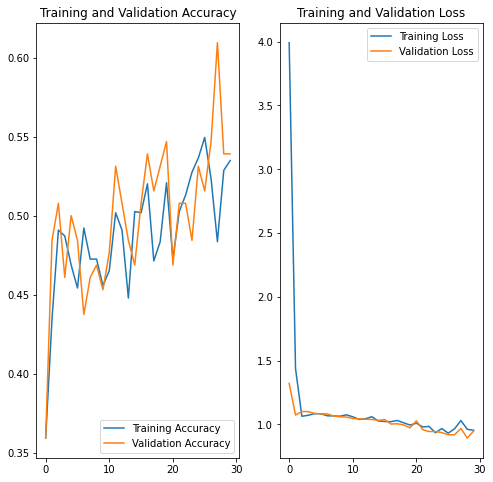

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## モデルの精度が低いのでVGG16を導入してファインチューンングを行なってモデルの作成を行う。

In [21]:
import os
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import numpy as np
import time

In [23]:
input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
# VGG16の図の緑色の部分（FC層）の作成
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(3, activation='softmax'))

# VGG16とFC層を結合してモデルを作成（完成図が上の図）
vgg_model = Model(vgg16.input, top_model(vgg16.output))

# VGG16の図の青色の部分は重みを固定（frozen）
for layer in vgg_model.layers[:15]:
    layer.trainable = False

# 多クラス分類を指定
vgg_model.compile(loss='sparse_categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

In [36]:
# ファイル名に(`str.format`を使って)エポック数を埋め込みます
checkpoint_path = "training_3/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    # 重みを5エポックごとに保存します
    period=5)

history2 = vgg_model.fit_generator(
    train_data_gen,
    steps_per_epoch=3,
    epochs=20,
    validation_data=val_data_gen,
    validation_steps=1,
    callbacks = [cp_callback]
)

Epoch 1/20
3/3 [==============================] - 8s 3s/step - loss: 0.4936 - accuracy: 0.7656 - val_loss: 0.3698 - val_accuracy: 0.8438
Epoch 2/20
3/3 [==============================] - 11s 4s/step - loss: 0.4264 - accuracy: 0.8059 - val_loss: 0.3738 - val_accuracy: 0.8594
Epoch 3/20
3/3 [==============================] - 11s 4s/step - loss: 0.3768 - accuracy: 0.8464 - val_loss: 0.4593 - val_accuracy: 0.8906
Epoch 4/20
3/3 [==============================] - 12s 4s/step - loss: 0.3816 - accuracy: 0.8095 - val_loss: 0.1788 - val_accuracy: 0.9375
Epoch 5/20
3/3 [==============================] - ETA: 0s - loss: 0.3860 - accuracy: 0.8498
Epoch 00005: saving model to training_3/cp-0005.ckpt
3/3 [==============================] - 9s 3s/step - loss: 0.3860 - accuracy: 0.8498 - val_loss: 0.4060 - val_accuracy: 0.8828
Epoch 6/20
3/3 [==============================] - 9s 3s/step - loss: 0.3518 - accuracy: 0.8571 - val_loss: 0.4936 - val_accuracy: 0.8828
Epoch 7/20
3/3 [=========================

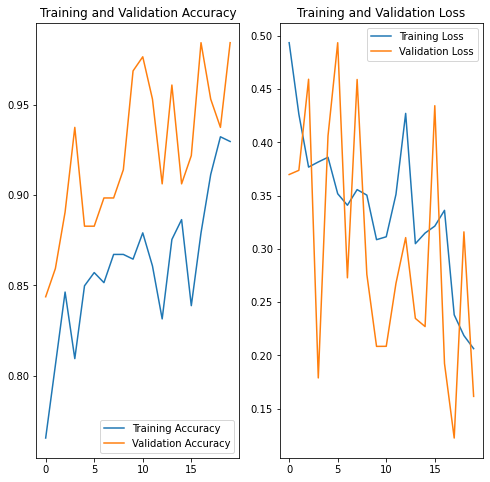

In [37]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(20)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()